In [2]:
import numpy as np
import networkx as nx
from scipy import sparse

G = nx.barabasi_albert_graph(1024,m=1)
degree_dict = nx.degree(G)
degree_list = [x[1] for x in degree_dict]
lap_matrix = sparse.diags(degree_list, 0)-nx.adjacency_matrix(G)
eigval = sparse.linalg.eigsh(lap_matrix, 1, which='LM',tol=0,return_eigenvectors=False)

print(eigval)
print(np.max(nx.laplacian_spectrum(G)))

[67.08563621]
67.08563621437182


In [3]:
import networkx as nx
import numpy as np
from scipy.linalg import expm, sinm, cosm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from tqdm import tqdm



def entropy(L,steps):
    w=np.linalg.eigvalsh(L.todense())
    wmax=np.max(w)
    #print(w[0])
    #print((w[1]-w[0])/w[0])
    #print((w[1]-w[0]))
    #w=nx.normalized_laplacian_spectrum(G)
    t1=-1#np.log10(1/np.max(w[w>1e-10]))-2
    t2=4#np.log10(10/np.min(w[w>1e-10]))+2
    t = np.logspace(t1,t2, int(steps))
    cont=0
    S=np.zeros(len(t))
    VarL=np.zeros(len(t))
    N=len(G.nodes())
    
    #L=nx.normalized_laplacian_matrix(G)
    #L1=L.todense()    
    Len=np.zeros(len(t))

    
    for tau in (t):       
        Tr=np.nansum(np.exp(-tau*w))
        T1=np.divide(np.exp(-w*tau),Tr)
        S[cont]=-np.nansum(T1*np.log(T1))/np.log(N)
        Med=np.nansum(np.multiply(w,np.exp(-tau*w)))/Tr
        Sqr=np.nansum(np.multiply(np.multiply(w,w),np.exp(-tau*w)))/Tr
        VarL[cont]=(Sqr-Med*Med)
        cont=cont+1
        
    dS=np.log(N)*np.diff(1-S)/np.diff(np.log(t))
    return 1-S,dS,VarL, t,wmax

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.60it/s]


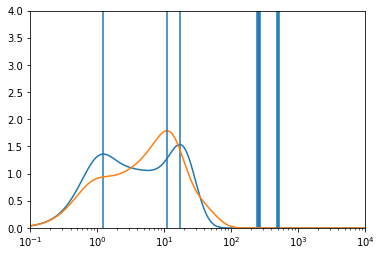

In [16]:
import scipy as sp
import scipy.sparse  # call as sp.sparse
import random 
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import igraph as ig
from scipy.signal import argrelextrema

warnings.filterwarnings("ignore")
nste=np.int(2e3)
p=np.linspace(0,0.25,2)
Var=np.zeros(len(p))
cont=0
nreps=1
L=16
H = nx.grid_2d_graph(L,L, periodic=True)
#H =nx.triangular_lattice_graph(30, 30, periodic=True)
#H=nx.hexagonal_lattice_graph(20, 20, periodic=True)
mapping = {old_label:new_label for new_label, old_label in enumerate(H.nodes())}
G = nx.relabel_nodes(H, mapping)
nedges=len(G.edges())

for p1 in (p):
    C=np.zeros(nste-1)
    C2=np.zeros(nste-1)
    w1=0
    for i in tqdm(range(nreps)):
        #Nnod=0
        #while (Nnod!=512):
        #    G1=ig.Graph.Erdos_Renyi(n=int(512),m=int(5*512/2),directed = False, loops = False)
        #    Gcc = G1.connected_components(mode='weak')
        #    G0 = G1.subgraph(Gcc[0])
        #    G=G0.to_networkx()
        #    Nnod=len(G.nodes())

        #nedges=len(G.edges())
        p1=p[cont]
        ransample = random.sample(range(nedges), int(p1*nedges))
        #
        all_weights = {e: 1 for e in G.edges()}
        neg_weights = {e: -1 for i,e in enumerate(G.edges()) if i in ransample}
        #
        nx.set_edge_attributes(G, values=all_weights, name='weight')
        nx.set_edge_attributes(G, values=neg_weights, name='weight')

        A = nx.to_scipy_sparse_array(G, format="csr")
        #A1 = np.abs(nx.to_scipy_sparse_array(G, format="csr"))
        n, m = A.shape
        D = sp.sparse.csr_array(sp.sparse.spdiags((np.abs(A).sum(axis=1)), 0, m, n, format="csr"))
        L=D-A
        
        #diags = np.abs(A).sum(axis=1)
        # TODO: rm csr_array wrapper when spdiags can produce arrays
        #D = sp.sparse.csr_array(sp.sparse.spdiags(diags, 0, m, n, format="csr"))
        #L1 = D - A
        #with sp.errstate(divide="ignore"):
        #        diags_sqrt = 1.0 / np.sqrt(diags)
        #diags_sqrt[np.isinf(diags_sqrt)] = 0
        # TODO: rm csr_array wrapper when spdiags can produce arrays
        #DH = sp.sparse.csr_array(sp.sparse.spdiags(diags_sqrt, 0, m, n, format="csr"))
        #L= DH @ (L1 @ DH)

        [S,dS,VarL,t,wmax]=entropy(L,2e3)
        #print(np.max(S))
        #idx=(np.where(S>0.99)[0][0])
        #dS[idx:len(dS)]=0
        C=C+dS
        C2=C2+np.square(dS)
        #plt.plot(t,S)
        w1=w1+wmax
    t1 = (t[1:]+t[:-1])/2.0
    plt.plot(t1,C/nreps,label=p[cont])
    
    
    #plt.axhline(y=1)
    #plt.legend(ncol=2,loc='lower left')
    plt.yscale('linear')
    plt.ylim(0,4)
    plt.xlim(1e-1,1e4)
    plt.xscale('log')   
    Var[cont]=np.sum(C2/nreps-(C/nreps)*(C/nreps))
    dS2=np.diff(C/nreps)/np.diff(np.log(t1))
    idx_pek=np.min(argrelextrema(C, np.greater))
    #print(argrelextrema(C, np.greater))
    for idx in argrelextrema(C, np.greater)[0]:
        plt.axvline(x=t1[idx])
    #dS2[dS2>1]=0
    #dS2[dS2<1]=0
    Var[cont]=t1[idx_pek]
    cont=cont+1

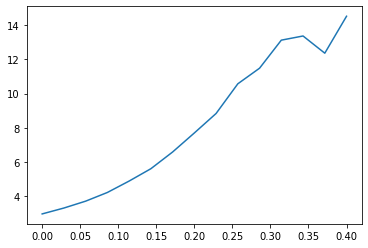

In [10]:
plt.plot(p,Var)


-0.0033672053811330724


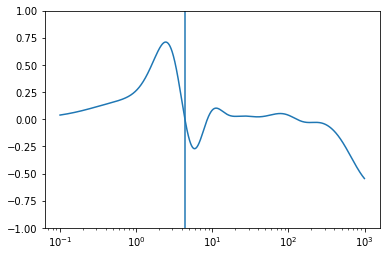

In [3]:
from scipy.signal import argrelextrema
t2 = (t1[1:]+t1[:-1])/2.0
idx_pek=np.min(argrelextrema(C, np.greater))
#idx_pek=np.min(np.where(dS2<0))-1
print(dS2[idx_pek])
plt.axvline(x=t2[idx_pek])
plt.plot(t2,dS2)
plt.ylim(-1,1)
plt.xscale('log')

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.20it/s]


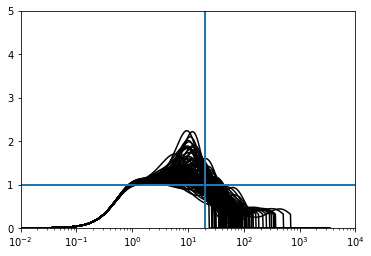

In [120]:
for i in tqdm(range(nreps)):
    p1=0.16
    ransample = random.sample(range(nedges), int(p1*nedges))
    #
    all_weights = {e: 1 for e in G.edges()}
    neg_weights = {e: -1 for i,e in enumerate(G.edges()) if i in ransample}
    #
    nx.set_edge_attributes(G, values=all_weights, name='weight')
    nx.set_edge_attributes(G, values=neg_weights, name='weight')

    A = nx.to_scipy_sparse_array(G, format="csr")
    A1 = np.abs(nx.to_scipy_sparse_array(G, format="csr"))
    n, m = A.shape
    D = sp.sparse.csr_array(sp.sparse.spdiags((A1.sum(axis=1)), 0, m, n, format="csr"))
    L=D-A

    [S,dS,VarL,t]=entropy(L,1e3)
    idx=np.min(np.where(S>=0.98))
    dS[idx:len(dS)]=0
    t1 = (t[1:]+t[:-1])/2.0
    plt.plot(t1,dS,color='black')

    plt.axvline(x=20)
    plt.axhline(y=1)

    plt.yscale('linear')
    plt.ylim(0,5)
    plt.xlim(1e-2,1e4)
    plt.xscale('log')

In [118]:
print((np.where(dS>=5)))

(array([], dtype=int64),)


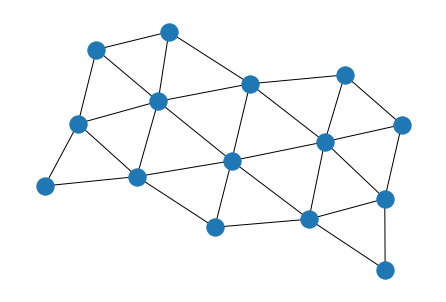

In [188]:
G=nx.triangular_lattice_graph(4, 4, periodic=False)
nx.draw(G)

In [223]:
print(neg_weights/all_weights)

TypeError: unsupported operand type(s) for /: 'dict' and 'dict'

In [413]:
print(nx.hexagonal_lattice_graph(20, 20, periodic=True))

Graph with 800 nodes and 1200 edges
